## Importing data & libraries

In [1]:
import os
import cv2
import json
import random

import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from PIL import Image
from numpy.random import seed
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.models import Model
from keras import layers,models
from keras.models import Sequential
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.layers import Input, Lambda, Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import array_to_img, img_to_array, load_img

## Preparing the data

In [2]:
df = pd.read_csv('./input/skin-metadata.csv')

In [3]:
df.shape

(10015, 7)

In [4]:
df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

/Users/sparshbohra/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='dx', ylabel='count'>

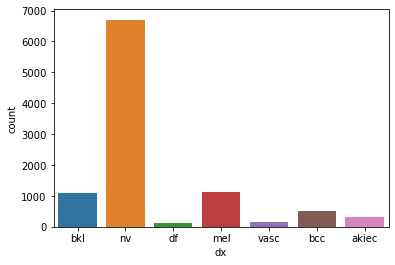

In [5]:
sns.countplot(df['dx'])

In [6]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419.jpg,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030.jpg,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769.jpg,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661.jpg,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633.jpg,bkl,histo,75.0,male,ear


In [7]:
df1 = df[['image_id', 'dx']].copy()

In [8]:
df1.head()

,image_id,dx
0,ISIC_0027419.jpg,bkl
1,ISIC_0025030.jpg,bkl
2,ISIC_0026769.jpg,bkl
3,ISIC_0025661.jpg,bkl
4,ISIC_0031633.jpg,bkl


## Images to Array

In [9]:
print(os.listdir('./input/'))

['HAM10000_metadata.numbers', 'HAM10000-metadata.csv', '.DS_Store', 'images_dataset', 'HAM10000_images_part_1', 'HAM10000_metadata2.csv', 'HAM_metadata.csv', 'HAM10000_metadata2.numbers', 'skin-metadata.csv', 'skin-metadata copy.csv', '.ipynb_checkpoints', 'HAM10000_images_part_2', 'HAM10000_metadata.csv']


In [10]:
path = './input/'
images_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*', '*.jpg'))}

In [11]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [12]:
skin_df = pd.read_csv(os.path.join(path, 'HAM10000-metadata.csv'))

In [13]:
skin_df['path'] = skin_df['image_id'].map(images_path.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [14]:
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      10015 non-null  object 
 1   image_id       10015 non-null  object 
 2   dx             10015 non-null  object 
 3   dx_type        10015 non-null  object 
 4   age            9958 non-null   float64
 5   sex            10015 non-null  object 
 6   localization   10015 non-null  object 
 7   path           10015 non-null  object 
 8   cell_type      10015 non-null  object 
 9   cell_type_idx  10015 non-null  int8   
dtypes: float64(1), int8(1), object(8)
memory usage: 714.1+ KB


In [16]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

In [17]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./input/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[191, 153, 195], [191, 154, 195], [192, 150,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./input/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[24, 13, 22], [24, 14, 26], [30, 18, 37], [4..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./input/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[186, 128, 139], [191, 134, 149], [197, 143,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./input/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[23, 11, 18], [31, 16, 26], [52, 30, 40], [7..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./input/HAM10000_images_part_1/ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[136, 93, 115], [153, 108, 132], [170, 126, ..."


In [18]:
skin_df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
image             0
dtype: int64

In [19]:
skin_df = skin_df.dropna()

In [20]:
skin_df.shape

(9958, 11)

In [21]:
from sklearn.utils import shuffle
skin_df = shuffle(skin_df)

In [22]:
skin_df.reset_index(inplace=True, drop=True) 

In [23]:
# Checking the image size distribution

skin_df['image'].map(lambda x: x.shape).value_counts()

(75, 75, 3)    9958
Name: image, dtype: int64

In [24]:
X = skin_df['image']
y = skin_df['cell_type_idx']

In [25]:
# Data normalization

X = X.values
X = X/255
X.shape

(9958,)

In [26]:
lst = []
for _ in X:
    lst.append(_)
X = np.array(lst)
print(X.shape)

(9958, 75, 75, 3)


## Splitting the data

In [27]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=28)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20,random_state=28)

In [28]:
from keras.utils.np_utils import to_categorical

y_test = to_categorical(y_test, num_classes = 7)
y_train = to_categorical(y_train, num_classes = 7)
y_val = to_categorical(y_val , num_classes=7)

In [29]:
# We only require test data

print ("X shape: " + str(X.shape))
print ("number of test examples = " + str(y_test.shape[0]))
print ("Y_test shape: " + str(y_test.shape))

X shape: (9958, 75, 75, 3)
number of test examples = 1992
Y_test shape: (1992, 7)


## Data augmentation

In [222]:
datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input)

In [223]:
train_generator = datagen.flow_from_dataframe(
    df1,
    directory = './input/HAM10000_images_part_1/',
    x_col = 'image_id',
    y_col = 'dx',
    target_size = (75, 75),
    class_mode = 'categorical',
    batch_size = 32)

Found 10015 validated image filenames belonging to 7 classes.


## Building the model

In [224]:
skinModel = InceptionV3(include_top = False, weights = 'imagenet', input_shape = (75, 75, 3))

In [225]:
skinModel.trainable = False

In [226]:
model = models.Sequential()
model.add(skinModel)

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))

model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

In [227]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 1799      
Total params: 22,984,999
Trainable params: 1,182,215
Non-trainable params: 21,802,784
__________________________________

In [231]:
model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [232]:
train_steps = np.ceil(train_generator.n / train_generator.batch_size)

In [294]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

monitor = EarlyStopping(monitor='val_loss', 
                        min_delta=1e-3, 
                        patience=5, verbose=1, 
                        restore_best_weights=True)

history = model.fit(train_generator,
                    epochs = 40,
                    batch_size = 32,
                    steps_per_epoch = train_steps)

Epoch 1/40
313/313 [==============================] - 191s 609ms/step - loss: 0.8981 - accuracy: 0.6904
Epoch 2/40
313/313 [==============================] - 177s 567ms/step - loss: 0.8389 - accuracy: 0.7072
Epoch 3/40
313/313 [==============================] - 185s 592ms/step - loss: 0.7991 - accuracy: 0.7208
Epoch 4/40
313/313 [==============================] - 169s 541ms/step - loss: 0.7621 - accuracy: 0.7269
Epoch 5/40
313/313 [==============================] - 179s 572ms/step - loss: 0.7323 - accuracy: 0.7418
Epoch 6/40
313/313 [==============================] - 165s 526ms/step - loss: 0.6987 - accuracy: 0.7501
Epoch 7/40
313/313 [==============================] - 189s 603ms/step - loss: 0.6568 - accuracy: 0.7624
Epoch 8/40
313/313 [==============================] - 175s 559ms/step - loss: 0.6184 - accuracy: 0.7710
Epoch 9/40
313/313 [==============================] - 193s 615ms/step - loss: 0.5907 - accuracy: 0.7876
Epoch 10/40
313/313 [==============================] - 585s 2s/s

## Prediction

In [32]:
from tensorflow import keras
model1 = keras.models.load_model('./server/models/cancerModelV1.h5')

In [33]:
from tensorflow import keras
model2 = keras.models.load_model('./server/models/cancerModelV2.h5')

In [34]:
preds = model1.evaluate(x_test, y_test, batch_size=32, verbose=1, sample_weight=None)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

63/63 [==============================] - 7s 112ms/step - loss: 9.1326 - accuracy: 0.1591

Loss = 9.13256549835205
Test Accuracy = 0.1591365486383438


In [35]:
preds = model2.evaluate(x_test, y_test, batch_size=32, verbose=1, sample_weight=None)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

63/63 [==============================] - 7s 113ms/step - loss: 10.7577 - accuracy: 0.1571

Loss = 10.75768756866455
Test Accuracy = 0.15712851285934448


## Test with single image

[[3.56966928e-02 1.09837905e-01 8.33620250e-01 1.16273435e-02
  2.78383843e-03 6.43083779e-03 3.14920430e-06]]


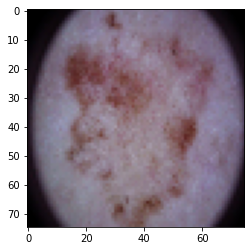

In [36]:
img_path = './input/HAM10000_images_part_1/ISIC_0032870.jpg'

img = image.load_img(img_path, target_size=(75, 75))
imshow(img)

x = image.img_to_array(img)
x = x/255
x = x.reshape(1, 75, 75, 3)

final_prediction = model2.predict(x)
print(final_prediction)

In [37]:
output_labels = ["Actinic Keratoses and Intraepithelial Carcinoma / Bowen's Disease (akiec)",
                 "Basal Cell Carcinoma (bcc)",
                 "Benign Keratosis-like Lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl)",
                 "Dermatofibroma (df)",
                 "Melanocytic Nevi (nv)",
                 "Vascular Lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc)",
                 "Melanoma (mel)"]

output_length = len(output_labels)

In [38]:
p = np.argmax(final_prediction[0])
print(output_labels[p])

Benign Keratosis-like Lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl)


## Model to feature extractor

In [39]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419.jpg,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030.jpg,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769.jpg,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661.jpg,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633.jpg,bkl,histo,75.0,male,ear


In [40]:
model_a = Model(model2.input, model2.layers[3].output)
model_a.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3_input (InputLay [(None, 75, 75, 3)]       0         
_________________________________________________________________
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
Total params: 22,851,872
Trainable params: 1,049,088
Non-trainable params: 21,802,784
_________________________________________________________________


In [41]:
predictions = model_a.predict(X)

In [52]:
predictions[0]

array([0.        , 0.        , 0.        , 3.06525   , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.1999509 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.3238518 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 3.1026974 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [53]:
len(predictions[0])

512

In [68]:
predictions.shape

(9958, 512)

In [69]:
type(predictions)

numpy.ndarray

In [72]:
# New dataset that will include features

data_df = skin_df

In [73]:
# Merge original dataframe with extracted features

complete_data = pd.concat([data_df, pd.DataFrame(predictions)], axis=1)

In [74]:
complete_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,...,502,503,504,505,506,507,508,509,510,511
0,HAM_0001971,ISIC_0025327,nv,histo,50.0,male,back,./input/HAM10000_images_part_1/ISIC_0025327.jpg,Melanocytic nevi,4,...,0.000000,0.0,0.0,0.0,0.000000,1.226828,1.929353,0.0,0.0,0.0
1,HAM_0006476,ISIC_0031877,nv,follow_up,45.0,male,back,./input/HAM10000_images_part_1/ISIC_0031877.jpg,Melanocytic nevi,4,...,0.000000,0.0,0.0,0.0,1.957106,0.000000,0.000000,0.0,0.0,0.0
2,HAM_0001806,ISIC_0026920,nv,follow_up,50.0,female,abdomen,./input/HAM10000_images_part_1/ISIC_0026920.jpg,Melanocytic nevi,4,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,HAM_0001845,ISIC_0026462,nv,follow_up,55.0,female,trunk,./input/HAM10000_images_part_1/ISIC_0026462.jpg,Melanocytic nevi,4,...,5.985096,0.0,0.0,0.0,3.274430,0.000000,0.000000,0.0,0.0,0.0
4,HAM_0004963,ISIC_0033071,nv,histo,45.0,male,upper extremity,./input/HAM10000_images_part_1/ISIC_0033071.jpg,Melanocytic nevi,4,...,0.370028,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


## Save the original and new model

In [57]:
model_json = model_a.to_json()
with open("model_a.json", "w") as json_file:
    json_file.write(model_json)

In [58]:
completemodel_json = model2.to_json()
with open("completemodel1.json", "w") as json_file:
    json_file.write(completemodel_json)

In [59]:
model_a.save_weights("model_a_weights.h5")
print("Saved model to disk")

Saved model to disk


In [60]:
model2.save_weights("completeweights.h5")
print("Saved model to disk")

Saved model to disk


## New dataset

In [75]:
# This dataset has original text data with the extracted features merged

complete_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,...,502,503,504,505,506,507,508,509,510,511
0,HAM_0001971,ISIC_0025327,nv,histo,50.0,male,back,./input/HAM10000_images_part_1/ISIC_0025327.jpg,Melanocytic nevi,4,...,0.000000,0.0,0.0,0.0,0.000000,1.226828,1.929353,0.0,0.0,0.0
1,HAM_0006476,ISIC_0031877,nv,follow_up,45.0,male,back,./input/HAM10000_images_part_1/ISIC_0031877.jpg,Melanocytic nevi,4,...,0.000000,0.0,0.0,0.0,1.957106,0.000000,0.000000,0.0,0.0,0.0
2,HAM_0001806,ISIC_0026920,nv,follow_up,50.0,female,abdomen,./input/HAM10000_images_part_1/ISIC_0026920.jpg,Melanocytic nevi,4,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,HAM_0001845,ISIC_0026462,nv,follow_up,55.0,female,trunk,./input/HAM10000_images_part_1/ISIC_0026462.jpg,Melanocytic nevi,4,...,5.985096,0.0,0.0,0.0,3.274430,0.000000,0.000000,0.0,0.0,0.0
4,HAM_0004963,ISIC_0033071,nv,histo,45.0,male,upper extremity,./input/HAM10000_images_part_1/ISIC_0033071.jpg,Melanocytic nevi,4,...,0.370028,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [78]:
complete_data['localization'].value_counts()

back               2192
lower extremity    2077
trunk              1403
upper extremity    1116
abdomen            1021
face                743
chest               405
foot                317
unknown             187
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: localization, dtype: int64

In [79]:
# The text cannot be processed as strings, so it will be one hot encoded

In [80]:
dxtype_df = pd.get_dummies(complete_data['dx_type'], drop_first = False)
complete_data = pd.concat([dxtype_df, complete_data], axis = 1)

# complete_data.drop(['dx_type'], axis =1 , inplace = True)
complete_data.head()

,confocal,consensus,follow_up,histo,lesion_id,image_id,dx,dx_type,age,sex,...,502,503,504,505,506,507,508,509,510,511
0,0,0,0,1,HAM_0001971,ISIC_0025327,nv,histo,50.0,male,...,0.000000,0.0,0.0,0.0,0.000000,1.226828,1.929353,0.0,0.0,0.0
1,0,0,1,0,HAM_0006476,ISIC_0031877,nv,follow_up,45.0,male,...,0.000000,0.0,0.0,0.0,1.957106,0.000000,0.000000,0.0,0.0,0.0
2,0,0,1,0,HAM_0001806,ISIC_0026920,nv,follow_up,50.0,female,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0,0,1,0,HAM_0001845,ISIC_0026462,nv,follow_up,55.0,female,...,5.985096,0.0,0.0,0.0,3.274430,0.000000,0.000000,0.0,0.0,0.0
4,0,0,0,1,HAM_0004963,ISIC_0033071,nv,histo,45.0,male,...,0.370028,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [81]:
localization_df = pd.get_dummies(complete_data['localization'], drop_first = False)
complete_data = pd.concat([localization_df, complete_data], axis = 1)

# complete_data.drop(['dx_type'], axis = 1, inplace = True)
complete_data.head()

,abdomen,acral,back,chest,ear,face,foot,genital,hand,lower extremity,...,502,503,504,505,506,507,508,509,510,511
0,0,0,1,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.000000,1.226828,1.929353,0.0,0.0,0.0
1,0,0,1,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,1.957106,0.000000,0.000000,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,5.985096,0.0,0.0,0.0,3.274430,0.000000,0.000000,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.370028,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [82]:
sex_df = pd.get_dummies(complete_data['sex'], drop_first = False)
sex_df.drop(['unknown'], axis = 1, inplace = True)
complete_data = pd.concat([sex_df, complete_data], axis = 1)

# complete_data.drop(['dx_type'], axis = 1, inplace = True)
complete_data.head()

,female,male,abdomen,acral,back,chest,ear,face,foot,genital,...,502,503,504,505,506,507,508,509,510,511
0,0,1,0,0,1,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.000000,1.226828,1.929353,0.0,0.0,0.0
1,0,1,0,0,1,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,1.957106,0.000000,0.000000,0.0,0.0,0.0
2,1,0,1,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,1,0,0,0,0,0,0,0,0,0,...,5.985096,0.0,0.0,0.0,3.274430,0.000000,0.000000,0.0,0.0,0.0
4,0,1,0,0,0,0,0,0,0,0,...,0.370028,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [83]:
complete_data.shape

(9958, 544)

In [84]:
X_labels = complete_data.drop(['lesion_id','image_id','dx_type','dx','path','cell_type','cell_type_idx',
                               'sex','path','localization','image'], axis = 1, inplace = False)
y_label = complete_data['cell_type_idx']

In [85]:
X_labels.head()

,female,male,abdomen,acral,back,chest,ear,face,foot,genital,...,502,503,504,505,506,507,508,509,510,511
0,0,1,0,0,1,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.000000,1.226828,1.929353,0.0,0.0,0.0
1,0,1,0,0,1,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,1.957106,0.000000,0.000000,0.0,0.0,0.0
2,1,0,1,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,1,0,0,0,0,0,0,0,0,0,...,5.985096,0.0,0.0,0.0,3.274430,0.000000,0.000000,0.0,0.0,0.0
4,0,1,0,0,0,0,0,0,0,0,...,0.370028,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [86]:
X_labels.shape

(9958, 534)

## Saving the newly created dataset

In [90]:
complete_data.to_csv('skin_data_v2.csv')

In [91]:
print(x_test.shape)
print(y_test.shape)

(1992, 75, 75, 3)
(1992, 7)


In [92]:
# Must convert back to label encoding

print(type(y_test))
print(y_test[10])

<class 'numpy.ndarray'>
[0. 0. 0. 0. 1. 0. 0.]


In [93]:
y_test2 = np.array(y_test)

In [94]:
y_test2

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [95]:
y_test2 = np.where(y_test2)[1]

In [96]:
preds = model2.predict(x_test)

In [97]:
lst = []
for a in preds:
    lst.append(np.argmax(a))

In [98]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## CNN Model evaluation

In [99]:
confusion_matrix(lst, y_test2)

array([[  17,    5,    4,    0,    2,    5,    0],
       [   8,   32,   14,    0,    6,   12,    4],
       [  35,   29,  110,    3,   64,   64,    0],
       [   0,    3,    0,    3,    3,    0,    0],
       [   0,    2,    4,    0,   15,   38,    1],
       [  18,   22,   82,   11, 1207,  122,   19],
       [   0,    0,    1,    0,   12,    1,   14]])

In [100]:
accuracy_score(lst, y_test2)

0.1571285140562249

In [101]:
print(classification_report(y_test2, lst))

              precision    recall  f1-score   support

           0       0.52      0.22      0.31        78
           1       0.42      0.34      0.38        93
           2       0.36      0.51      0.42       215
           3       0.33      0.18      0.23        17
           4       0.25      0.01      0.02      1309
           5       0.08      0.50      0.14       242
           6       0.50      0.37      0.42        38

    accuracy                           0.16      1992
   macro avg       0.35      0.30      0.28      1992
weighted avg       0.27      0.16      0.12      1992



## Importing the new dataset

In [102]:
skin_df = pd.read_csv('skin_data_v2.csv')

In [103]:
skin_df.drop(['Unnamed: 0'],axis=1,inplace=True)
skin_df.head()

,female,male,abdomen,acral,back,chest,ear,face,foot,genital,...,502,503,504,505,506,507,508,509,510,511
0,0,1,0,0,1,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.000000,1.226827,1.929353,0.0,0.0,0.0
1,0,1,0,0,1,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,1.957106,0.000000,0.000000,0.0,0.0,0.0
2,1,0,1,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,1,0,0,0,0,0,0,0,0,0,...,5.985095,0.0,0.0,0.0,3.274430,0.000000,0.000000,0.0,0.0,0.0
4,0,1,0,0,0,0,0,0,0,0,...,0.370028,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [104]:
!pip install pycaret

In [105]:
X_labels = skin_df.drop(['lesion_id','image_id','dx','dx_type','sex','localization',
                         'path','cell_type','cell_type_idx','image'], axis=1,inplace=False)
y_label = skin_df['cell_type_idx']

In [106]:
data_classification = pd.concat([X_labels, y_label], axis = 1)
data_classification.fillna(data_classification['age'].mean(), inplace = True)

In [107]:
# import the classification module 
from pycaret import classification
from pycaret.classification import *

# setup the environment 
classification_setup = classification.setup(data = data_classification, target = 'cell_type_idx')

,Description,Value
0,session_id,5653
1,Target,cell_type_idx
2,Target Type,Multiclass
3,Label Encoded,"0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6"
4,Original Data,"(9958, 535)"
5,Missing Values,False
6,Numeric Features,473
7,Categorical Features,61
8,Ordinal Features,False
9,High Cardinality Features,False


In [108]:
# build the xgboost model

classification_xgb = classification.create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7489,0.9283,0.4158,0.7296,0.7363,0.4957,0.4977
1,0.7805,0.9356,0.4646,0.7656,0.7658,0.5488,0.5533
2,0.7747,0.9292,0.4742,0.7550,0.7609,0.5485,0.5511
3,0.7719,0.9384,0.4592,0.7543,0.7564,0.5295,0.5342
4,0.7647,0.9414,0.4711,0.7429,0.7474,0.5110,0.5170
5,0.7547,0.9367,0.4330,0.7301,0.7385,0.4963,0.5004
6,0.7504,0.9244,0.4364,0.7311,0.7360,0.4885,0.4923
7,0.7661,0.9263,0.4197,0.7417,0.7469,0.5133,0.5199
8,0.7862,0.9397,0.4857,0.7604,0.7682,0.5552,0.5622
9,0.7618,0.9323,0.4591,0.7398,0.7425,0.5011,0.5086


In [109]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_labels, y_label, train_size = 0.8, random_state = 40)

In [110]:
import xgboost as xgb

In [111]:
classifier = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=-1, nthread=None,
                                            objective='binary:logistic',
                                            random_state=1855, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=0)

In [112]:
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, nthread=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=1855, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=1855, silent=None,
              subsample=1, tree_method='exact', use_label_encoder=True,
              validate_parameters=1, ...)

## CNN + Xgboost evaluation

In [113]:
y_pred = classifier.predict(X_test)

In [114]:
confusion_matrix(y_test, y_pred)

array([[  21,    9,   20,    1,   16,    9,    0],
       [   5,   40,    6,    0,   35,   10,    0],
       [   7,   14,   96,    0,   74,   29,    1],
       [   0,    0,    2,    8,   18,    0,    0],
       [   2,    7,   24,    0, 1271,   24,    0],
       [   4,    7,   14,    0,  104,   86,    1],
       [   1,    1,    1,    0,   14,    1,    9]])

In [115]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.28      0.36        76
           1       0.51      0.42      0.46        96
           2       0.59      0.43      0.50       221
           3       0.89      0.29      0.43        28
           4       0.83      0.96      0.89      1328
           5       0.54      0.40      0.46       216
           6       0.82      0.33      0.47        27

    accuracy                           0.77      1992
   macro avg       0.67      0.44      0.51      1992
weighted avg       0.75      0.77      0.75      1992



In [190]:
classifier.save_model('classifier_v1.model')

In [116]:
import pickle
file_name = "xgb_classifier.pkl"

# save
pickle.dump(classifier, open(file_name, "wb"))